<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/HelmerNylen/HelmerNylen_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 5: Quadrature**
**Helmer Nylén**

# **Abstract**

In this lab we implement 2-point Gauss quadrature and Monte Carlo quadrature over the unit interval, and 3-point edge midpoint quadrature and Monte Carlo quadrature over the reference triangle. All four methods are tested: the Monte Carlo methods for convergence speed and the other two for accuracy. All implementations were found to be correct.

#**About the code**

In [1]:
"""This program is a lab report in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Helmer Nylén (helmern@kth.se)
# Parts of the relevant theory was discussed with Jonas Nylund

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
import numpy as np
fac = np.math.factorial
from random import randint
from scipy.optimize import root
import numpy.polynomial.polynomial as P

from matplotlib import pyplot as plt

# **Introduction**

In this lab we aim to implement 2-point Gauss quadrature and Monte Carlo quadrature over the unit interval, and 3-point edge midpoint quadrature and Monte Carlo quadrature over the reference triangle. The reference triangle is here taken to refer to the 2D triangle with vertices in $(0,0)$, $(1,0)$ and $(0,1)$ - other works may use other definitions.

# **Methods**

## 2-point Gauss quadrature on [0, 1]


For 2-point Gauss quadrature in 1D all cubic polynomials $p \in \mathcal{P}^3([0,1])$ should be exact. Analogously to example 11.3, chapter 11.3 in the lecture notes we compute the integral for an arbitrary third-degree polynomial $p(x) = \sum_{i=0}^3 c_i x^i$ to determine the quadrature points $x_0, x_1$ and weights $w_0, w_1$.
$$\int_0^1 p(x)dx = p(x_0)w_0 + p(x_1)w_1$$
$$\int_0^1 \sum_{i=0}^3 c_i x^i dx = \sum_{i=0}^3 c_i x_0^i w_0 + \sum_{i=0}^3 c_i x_1^i w_1$$
$$\frac{c_3}{4} + \frac{c_2}{3} + \frac{c_1}{2} + c_0 = (c_3 x_0^3 + c_2 x_0^2 + c_1 x_0 + c_0) w_0 + (c_3 x_1^3 + c_2 x_1^2 + c_1 x_1 + c_0) w_1$$
$$c_3(x_0^3 w_0 + x_1^3 w_1 - \frac{1}{4}) + c_2(x_0^2 w_0 + x_1^2 w_1 - \frac{1}{3}) + c_1(x_0 w_0 + x_1 w_1 - \frac{1}{2}) + c_0(w_0 + w_1 - 1) = 0$$
Since the equality must hold for arbitrary choices of $c_i$ we get a system of equations as follows:
\begin{align}
x_0^3 w_0 + x_1^3 w_1 - \frac{1}{4} &= 0 \\
x_0^2 w_0 + x_1^2 w_1 - \frac{1}{3} &= 0 \\
x_0 w_0 + x_1 w_1 - \frac{1}{2} &= 0 \\
w_0 + w_1 - 1 &= 0
\end{align}
Solving this equation system using a numerical solver in `scipy` we get:

In [3]:
def _get_gauss_quad_params(p = False):
  x0, x1, w0, w1 = root(lambda x: (
      x[0]**3 * x[2] + x[1] ** 3 * x[3] - 1/4,
      x[0]**2 * x[2] + x[1] ** 2 * x[3] - 1/3,
      x[0]    * x[2] + x[1]      * x[3] - 1/2,
      x[2] + x[3] - 1
    ), np.ones(4) * 0.5).x
  if p:
    print(f"x0: {x0}\nx1: {x1}\nw0: {w0}\nw1: {w1}")
  return np.array([x0, x1]), np.array([w0, w1])

_gauss_quad_params = _get_gauss_quad_params(True)

x0: 0.7886751345948164
x1: 0.21132486540527382
w0: 0.49999999999993183
w1: 0.5000000000000682


We define a general quadrature function to reuse and the specific 2-point Gauss quadrature using our computed parameters.

In [0]:
def quad(f, params):
  assert hasattr(f, '__call__')
  return sum(f(x) * w for x, w in zip(*params))

def gauss_quad(f):
  return quad(f, _gauss_quad_params)

### Testing

We test our implementation by comparing the result to the exact solution $\sum_{i=0}^3 \frac{c_i}{i+1}$ for random third-degree polynomials.

In [0]:
def test_gauss():
  c = np.random.rand(4) * 2 - 1
  f = lambda x: P.polyval(x, c)
  
  assert np.isclose(gauss_quad(f), c[3] / 4 + c[2] / 3 + c[1] / 2 + c[0])

## 3-point edge midpoint quadrature over the reference triangle

By example 11.5, chapter 11.3 we have the quadrature points
$$x_0 = (1/2, 0), x_1 = (1/2, 1/2), x_2 = (0, 1/2)$$
with weights $w_0 = w_1 = w_2 = \frac16$, which should yield exact results for quadratic integrands over the reference triangle $(0,0),(1,0),(0,1)$. Using the above quadrature function we get the following implementation:

In [0]:
_midpoint_quad_params = (np.array([[0.5, 0], [0.5, 0.5], [0, 0.5]]), np.ones(3) / 6)
def midpoint_quad(f):
  return quad(f, _midpoint_quad_params)

To verify that the solution is exact for quadratic integrals we need to compute the exact solution. Let $p \in \mathcal{P}^N([0,1] \times [0,1])$ be an arbitrary polynomial of at most degree $N$ on the unit square defined by $$p(x,y) = \sum_{i=0}^N \sum_{j=0}^N c_{ij} x^i y^j.$$ The integral over the reference triangle is given by 
\begin{align}
\int_0^1 \int_0^{1-x} \sum_{i=0}^N \sum_{j=0}^N c_{ij} x^i y^j dy dx &= \int_0^1 \left[ \sum_{i=0}^N \sum_{j=0}^N c_{ij} x^i \frac{y^{j+1}}{j+1} \right]_0^{1-x} dx \\
&= \int_0^1 \sum_{i=0}^N \sum_{j=0}^N \frac{c_{ij}}{j+1} x^i (1-x)^{j+1} dx \\
&= \sum_{i=0}^N \sum_{j=0}^N \frac{c_{ij}}{j+1} \int_0^1 x^i (1-x)^{j+1} dx\\
&= \sum_{i=0}^N \sum_{j=0}^N \frac{c_{ij}}{j+1} \frac{i!(j+1)!}{(i+j+2)!}\\
&= \sum_{i=0}^N \sum_{j=0}^N c_{ij} \frac{i!j!}{(i+j+2)!},
\end{align}
with some help from WolframAlpha for the last integral. Using the fact that $c_{ij} = 0$ for $i + j > N$ we get, in the quadratic case, $$\int_0^1 \int_0^{1-x} \sum_{i=0}^2 \sum_{j=0}^2 c_{ij} x^i y^j dy dx = \frac{c_{00}}{2} + \frac{c_{10} + c_{01}}{6} + \frac{c_{11}}{24} + \frac{c_{20} + c_{02}}{12}.$$

In [0]:
def test_midpoint():
  c = np.array([[np.random.rand() * 2 - 1 if i + j <= 2 else 0
                  for j in range(3)] 
                    for i in range(3)])
  f = lambda x: P.polyval2d(x[0], x[1], c)
  
  exact = c[0,0] / 2 + (c[1,0] + c[0,1]) / 6 + c[1,1] / 24 + (c[2,0] + c[0,2]) / 12
  assert np.isclose(midpoint_quad(f), exact)

## Monte Carlo quadrature over unit interval

By the result at the end of page 224, chapter 12.4, we can approximate the integral $\int_D f(x) dx$ of a function $f : D \rightarrow \mathbb{R}$ with $$\int_D f(x) dx \approx \frac{|D|}{n} \sum_{i=1}^n f(x_i),$$ where $D \subset \mathbb{R}^d$ and the $x_i$ are $n$ samples of random variables uniformly distributed on $D$.

On the unit interval in the 1D case we have $$\int_0^1 f(x)dx \approx \frac1n \sum_{i=1}^n f(x_i),$$ which we can implement using the generic quadrature function above by randomizing the quadrature points over $[0,1]$ and setting the weights to $\frac1n$ (or, equivalently, to setting them to 1 and then dividing by $n$ to avoid numerical errors for large $n$).

In [0]:
def monte_carlo(f, N):
  return quad(f, (np.random.rand(N), np.ones(N))) / N

We test this implementation to make sure that the error compared to the exact solution decays at a rate of $\frac{1}{\sqrt n}$. This can be done either by computing the coefficient of determination or simply by loglog-plotting the error over $n$ and observing the slope. We no longer need to restrict ourselves to third-degree polynomials, and can take arbitrary $p(x) = \sum_{i=0}^N c_i x^i$ with the exact solution $$\int_0^1 p(x) dx = \sum_{i=0}^N \frac{c_i}{i+1}.$$

In [0]:
def test_mc(n_rep = 20):
  degree = randint(1, 6)
  c = np.random.rand(1 + degree) * 2 - 1
  f = lambda x: P.polyval(x, c)
  exact = sum(c[i] / (i + 1) for i in range(degree + 1))
  
  ns = np.round(10 ** np.linspace(1, 5, 20)).astype(int)

  diff = []
  for n in ns:
    diff.append(sum(abs(monte_carlo(f, n) - exact) for _ in range(n_rep)) / n_rep)

  plt.figure()
  plt.loglog(ns, diff)
  plt.loglog(ns, diff[0] * np.sqrt(ns[0]) / np.sqrt(ns))
  plt.legend(('Mean error', '1 / sqrt(n)'))
  plt.xlabel('n')
  plt.ylabel('Error')
  plt.title('Unit interval Monte Carlo')

## Monte Carlo quadrature over reference triangle

Analogously to the above Monte Carlo implementation we get $$\iint_\text{tri} f(x)dx \approx \frac{|\text{tri}|}{n} \sum_{i=1}^n f(x_i) = \frac{1}{2n} \sum_{i=1}^n f(x_i).$$ The resulting 2D implementation is similar to the 1D version, except that we also need to provide the uniform sampling on the reference triangle. We can do this by simply sampling on the unit square $[0, 1] \times [0, 1]$ and mirroring any points $x_i = (x, y)$ which land outside the triangle, given by $x + y > 1$, back inside. This is done by replacing the point $x_i$ with $\tilde{x_i} = (1-x, 1-y)$, which is motivated by symmetry. The triangle $(0,1),(1,1),(1,0)$ forms an triangle with the same area which can be mapped to the reference triangle by $(x', y') = (1-x,1-y)$, and the boundary along the hypotenuse is given by $x + y = 1$.

In [0]:
def _random_reference_triangle(N):
  """Get N uniformly random points on the reference triangle"""
  res = np.random.rand(N, 2)
  outside = res.sum(1) > 1
  res[outside, :] = 1 - res[outside, :]
  assert (res.sum(1) <= 1).all()
  return res

def monte_carlo_2D(f, N):
  return (1/2) * quad(f, (_random_reference_triangle(N), np.ones(N))) / N

We test the implementation with arbitrary polynomials where the degree is not restricted to three, and know the exact solution from before: for $$p(x,y) = \sum_{i=0}^N \sum_{j=0}^N c_{ij} x^i y^j,$$ $$\int_0^1 \int_0^{1-x} p(x,y) dy dx = \sum_{i=0}^N \sum_{j=0}^N c_{ij} \frac{i!j!}{(i+j+2)!}.$$ We again make sure that the error converges at a rate of $\frac{1}{\sqrt{n}}$ by visual inspection.

In [0]:
def test_mc_2D(n_rep = 20):
  degree = randint(1, 6)
  c = np.array([[np.random.rand() * 2 - 1 if i + j <= 2 else 0
                  for j in range(degree)]
                    for i in range(degree)])
  f = lambda x: P.polyval2d(x[0], x[1], c)
  exact = sum(c[i, j] * fac(i) * fac(j) / fac(i + j + 2) for i in range(degree) for j in range(degree))
  
  ns = np.round(10 ** np.linspace(1, 5, 20)).astype(int)

  diff = []
  for n in ns:
    diff.append(sum(abs(monte_carlo_2D(f, n) - exact) for _ in range(n_rep)) / n_rep)
    
  plt.figure()
  plt.loglog(ns, diff)
  plt.loglog(ns, diff[0] * np.sqrt(ns[0]) / np.sqrt(ns))
  plt.legend(('Mean error', '1 / sqrt(n)'))
  plt.xlabel('n')
  plt.ylabel('Error')
  plt.title('Reference triangle Monte Carlo')

# **Results**

Gauss and midpoint tests passed


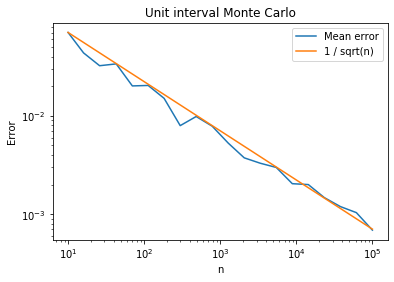

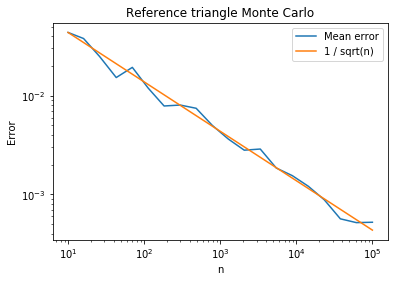

In [12]:
for i in range(1000):
  test_gauss()
  test_midpoint()
print("Gauss and midpoint tests passed")
  
test_mc()
test_mc_2D()

The tests for 2-point Gauss quadrature and 3-point midpoint quadrature both pass. Looking at the figures for the Monte Carlo methods we see that the mean error curves follow the $\frac{1}{\sqrt{n}}$-lines very well. Note that we have scaled the $\frac{1}{\sqrt{n}}$-lines to intersect the corresponding mean error at $n = 10^1$ to make the comparison easier.

# **Discussion**

Since all tests pass we can reasonably assume that the implementations are correct. Otherwise both the implementation and the supposedly correct solutions are conistently erroneous in the exact same way, which (while possible) seems unlikely.